In [246]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd

plt.style.use('seaborn-white')

In [34]:
# Read in Exoplanet Database csv
exo_df = pd.read_csv("pydata/exoplanet_database.csv", skiprows=[1])
print(list(exo_df.columns))

['STAR', 'COMP', 'ORBREF', 'ORBURL', 'RA', 'FIRSTREF', 'FIRSTURL', 'DEC', 'MSTAR', 'MSTARUPPER', 'MSTARLOWER', 'UMSTAR', 'RSTAR', 'RSTARUPPER', 'RSTARLOWER', 'URSTAR', 'DIST', 'DISTUPPER', 'DISTLOWER', 'UDIST', 'TEFF', 'TEFFUPPER', 'TEFFLOWER', 'UTEFF', 'LOGG', 'LOGGUPPER', 'LOGGLOWER', 'ULOGG', 'FE', 'FEUPPER', 'FELOWER', 'UFE']


In [144]:
# Collect list of stellar parameter files
stellar_param_files = glob.glob("pydata/sumout_files/*")

In [210]:
# Generate Stellar Parameter DataFrame
stellar_param_dict = {}
files = ["pydata/sumout_files/11Com_2012.m.sumout"]
for file in stellar_param_files:
    with open(file,'r') as f:
        for i, line in enumerate(f):
            if i == 0:
                star = f.readline().split(" ")[0].split("_")[0]
                #print(star)
                params = [elem for elem in f.readline().split(" ") if elem != '']
                #print(params)
                metallicity = params[-2]
                if '-' in metallicity:
                    metallicity = metallicity[4:]
                file_dict = {'Teff': float(params[2]), 'Log_g':float(params[6]), 'M/H':float(metallicity)}
                #print(file_dict)
                stellar_param_dict[star] = file_dict
                
param_df = pd.DataFrame.from_dict(stellar_param_dict, orient='index')

In [211]:
# Cross Reference the two Dataframes, generate a comparison Dataframe

cross_ref_dict = {}
for row in param_df.iterrows():
    logg, teff, metal = row[1][:]
    exo_df_subset = [s for s in list(exo_df['STAR']) if row[0].lower() in s.replace(' ','').lower()]
    if len(exo_df_subset) == 0:
        continue
    exo_match = exo_df[exo_df['STAR'] == exo_df_subset[0]]
    exo_match = exo_match.head(1) # If there's multiple planets multiple matchs will happen, just take the first one

    delta_teff = abs(teff - float(exo_match['TEFF']))
    delta_logg = abs(logg - float(exo_match['LOGG']))
    delta_metal = abs(metal - float(exo_match['FE']))
    match_dict = {'DELTATEFF': delta_teff, 'DELTALOGG':delta_logg, 'DELTAFE':delta_metal,
                 'UTEFF': float(exo_match['UTEFF']), 'ULOGG': float(exo_match['ULOGG']), 'UFE': float(exo_match['UFE'])}
    cross_ref_dict[row[0]] = match_dict

cross_ref_df = pd.DataFrame.from_dict(cross_ref_dict, orient='index')

Text(0.5, 0.98, 'Stellar Parameters vs Literature Values Comparison')

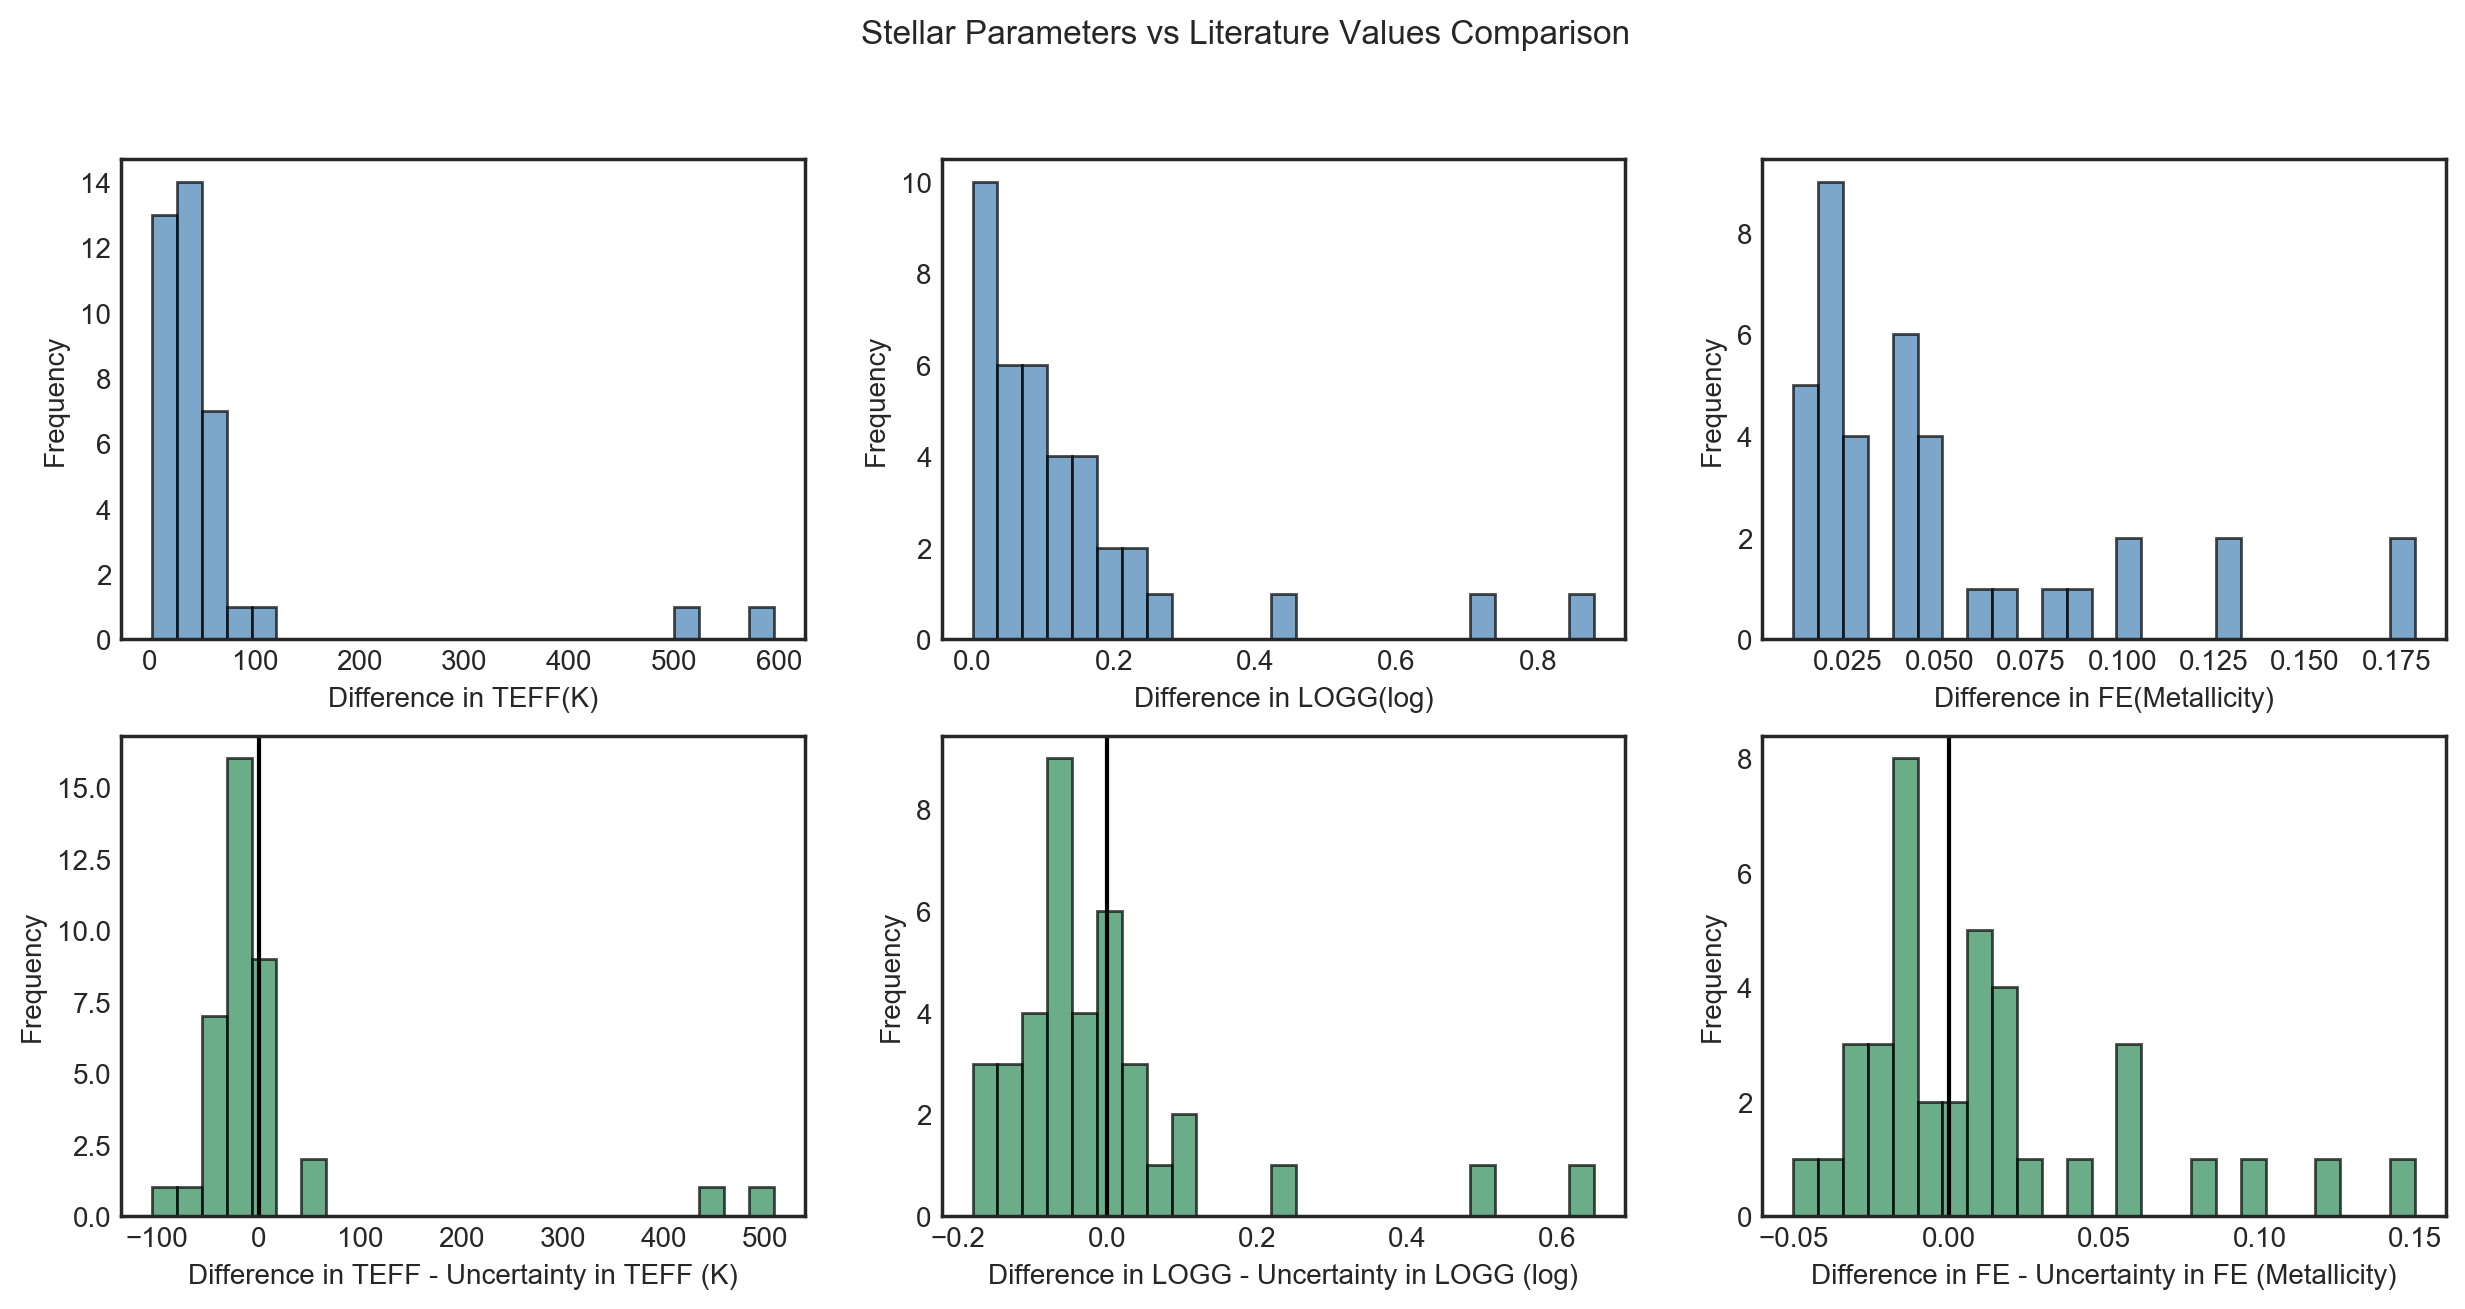

In [248]:
fig, axes = plt.subplots(2,3, figsize=(15,7), dpi = 200)
quantities = ['DELTATEFF', 'DELTALOGG', 'DELTAFE']
uncertainties = ['UTEFF', 'ULOGG', 'UFE']
units = ['K', 'log', 'Metallicity']
for idx,ax in enumerate(axes[0]):
    ax.hist(cross_ref_df[quantities[idx]], histtype='bar',ec='black', color = 'steelblue', alpha = 0.7, bins = 25)
    ax.set_xlabel("Difference in {}({})".format(quantities[idx][5:], units[idx]))
    ax.set_ylabel("Frequency")
    
for idx,ax in enumerate(axes[1]):
    ax.set_xlabel("Difference in {} - Uncertainty in {} ({})".format(quantities[idx][5:],quantities[idx][5:], units[idx]))
    ax.hist(cross_ref_df[quantities[idx]] - cross_ref_df[uncertainties[idx]], histtype='bar',ec='black', color='seagreen', alpha=0.7, bins=25)
    ax.set_ylabel("Frequency")
    ax.axvline(0, color='k')
fig.suptitle("Stellar Parameters vs Literature Values Comparison")    